In [13]:
!git clone https://github.com/haofeixu/gmflow.git

fatal: destination path 'gmflow' already exists and is not an empty directory.


In [48]:
from gmflow.gmflow.gmflow import GMFlow

In [15]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

gmflow_model = GMFlow(feature_channels=128, num_scales=1, upsample_factor=8, num_head=1, attention_type='swin', ffn_dim_expansion=4, num_transformer_layers=6).to(device)

In [16]:
!cp /content/drive/MyDrive/pretrained.zip  pretrained.zip

In [17]:
!unzip pretrained.zip

Archive:  pretrained.zip
replace pretrained/gmflow_chairs-1d776046.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [18]:
checkpoint = torch.load("/content/pretrained/gmflow_sintel-0c07dcb3.pth")

In [19]:
checkpoint["model"]

OrderedDict([('backbone.conv1.weight',
              tensor([[[[-2.2713e-02,  1.3497e-02, -5.1653e-04,  ...,  4.5507e-02,
                         -2.6293e-02,  1.0270e-03],
                        [ 7.1209e-02,  8.7196e-02,  3.0173e-02,  ...,  5.0663e-02,
                          3.0789e-04, -8.6394e-02],
                        [ 8.5214e-02,  1.4466e-01,  1.3213e-01,  ..., -1.7336e-02,
                         -8.4644e-02, -9.8008e-02],
                        ...,
                        [ 1.1521e-01,  1.6380e-01,  1.4935e-01,  ..., -3.5198e-01,
                         -5.1853e-01, -2.0422e-01],
                        [ 1.6283e-01,  1.0480e-01,  1.8769e-01,  ..., -1.6735e-01,
                         -2.3614e-01, -1.3604e-01],
                        [ 1.2207e-01,  1.9278e-01,  2.2927e-01,  ..., -1.7753e-02,
                         -3.3220e-03,  1.5301e-03]],
              
                       [[-3.1765e-02,  3.8316e-02, -1.1084e-02,  ...,  2.3227e-02,
                       

In [20]:
gmflow_model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [21]:
gmflow_model

GMFlow(
  (backbone): CNNEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
      

In [22]:
!pip install torchinfo

In [23]:
from torchinfo import summary

summary(gmflow_model)

Layer (type:depth-idx)                        Param #
GMFlow                                        --
├─CNNEncoder: 1-1                             --
│    └─Conv2d: 2-1                            9,408
│    └─InstanceNorm2d: 2-2                    --
│    └─ReLU: 2-3                              --
│    └─Sequential: 2-4                        --
│    │    └─ResidualBlock: 3-1                73,728
│    │    └─ResidualBlock: 3-2                73,728
│    └─Sequential: 2-5                        --
│    │    └─ResidualBlock: 3-3                144,480
│    │    └─ResidualBlock: 3-4                165,888
│    └─Sequential: 2-6                        --
│    │    └─ResidualBlock: 3-5                270,464
│    │    └─ResidualBlock: 3-6                294,912
│    └─Conv2d: 2-7                            16,512
├─FeatureTransformer: 1-2                     --
│    └─ModuleList: 2-8                        --
│    │    └─TransformerBlock: 3-7             525,056
│    │    └─TransformerB

In [52]:
import cv2

image_1 = cv2.imread("myimage001.jpg")
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)

image_2 = cv2.imread("myimage002.jpg")
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

In [25]:
image_2.shape

(820, 615, 3)

In [53]:
image_1 = torch.from_numpy(image_1).permute(2, 0, 1).float().to(device)
image_2 = torch.from_numpy(image_2).permute(2, 0, 1).float().to(device)


In [49]:
from gmflow.utils.utils import *

In [54]:
print("Before padding:")
print("image_1 shape:", image_1.shape)
print("image_2 shape:", image_2.shape)

padder1 = InputPadder(image_1.shape, padding_factor=16)
image_1, image_2 = padder1.pad(image_1[None], image_2[None])

print("After padding:")
print("image_1 shape:", image_1.shape)
print("image_2 shape:", image_2.shape)

Before padding:
image_1 shape: torch.Size([3, 820, 615])
image_2 shape: torch.Size([3, 820, 615])
After padding:
image_1 shape: torch.Size([1, 3, 832, 624])
image_2 shape: torch.Size([1, 3, 832, 624])


In [50]:
image_1.shape

torch.Size([1, 3, 824, 616])

In [55]:
with torch.no_grad():
  optical_flow_dict = gmflow_model(image_2, image_1, attn_splits_list=[2], corr_radius_list=[-1], prop_radius_list=[-1], pred_bidir_flow=True)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [56]:
optical_flow_dict

{'flow_preds': [tensor([[[[ 2.1000e+00,  2.1849e+00,  2.2697e+00,  ...,  1.6842e+00,
              8.3849e-01, -7.2021e-03],
            [ 2.1567e+00,  2.2293e+00,  2.3019e+00,  ...,  1.6896e+00,
              8.4134e-01, -6.8693e-03],
            [ 2.2134e+00,  2.2737e+00,  2.3341e+00,  ...,  1.6949e+00,
              8.4420e-01, -6.5364e-03],
            ...,
            [ 6.8763e-02,  1.4230e-01,  2.1585e-01,  ..., -3.1922e-01,
             -2.8413e-01, -2.4904e-01],
            [ 6.1150e-02,  1.3368e-01,  2.0622e-01,  ..., -3.4517e-01,
             -3.0784e-01, -2.7051e-01],
            [ 5.3537e-02,  1.2506e-01,  1.9659e-01,  ..., -3.7111e-01,
             -3.3155e-01, -2.9199e-01]],
  
           [[ 3.0036e-01,  3.2244e-01,  3.4452e-01,  ...,  5.2570e-01,
              5.3513e-01,  5.4456e-01],
            [-6.5037e-01, -6.3004e-01, -6.0970e-01,  ..., -3.2482e-01,
             -3.1951e-01, -3.1420e-01],
            [-1.6011e+00, -1.5825e+00, -1.5639e+00,  ..., -1.1753e+00,
      

In [58]:
optical_flow_prd = optical_flow_dict["flow_preds"][0]
fwd_flow = padder1.unpad(optical_flow_prd[0])[None] # [1, 2, H, W]
bwd_flow = padder1.unpad(optical_flow_prd[1])[None] # [1, 2, H, W]

In [60]:
b, c, h, w = fwd_flow.size()
y, x = torch.meshgrid(torch.arange(h), torch.arange(w)) # [H, W]

In [81]:
y

(torch.Size([1, 3, 832, 624]),
 tensor([[  0,   0,   0,  ...,   0,   0,   0],
         [  1,   1,   1,  ...,   1,   1,   1],
         [  2,   2,   2,  ...,   2,   2,   2],
         ...,
         [817, 817, 817,  ..., 817, 817, 817],
         [818, 818, 818,  ..., 818, 818, 818],
         [819, 819, 819,  ..., 819, 819, 819]]))

In [62]:
x

tensor([[  0,   1,   2,  ..., 612, 613, 614],
        [  0,   1,   2,  ..., 612, 613, 614],
        [  0,   1,   2,  ..., 612, 613, 614],
        ...,
        [  0,   1,   2,  ..., 612, 613, 614],
        [  0,   1,   2,  ..., 612, 613, 614],
        [  0,   1,   2,  ..., 612, 613, 614]])

In [65]:
wrapped_grid_using_fwd = torch.stack([x, y], dim=0)[None].float().to(device) + fwd_flow # [1, 2, H, W], [None] adds batch dimension

In [68]:
x.shape, y.shape

(torch.Size([820, 615]), torch.Size([820, 615]))

In [78]:
wrapped_grid_using_fwd = torch.stack([x, y], dim=0)[None].float().to(device) + fwd_flow # adds vectors to original locations to get new locations of pixels

# normalized between 0 and 1
normalized_wrapped_x_grid_fwd = 2 * wrapped_grid_using_fwd[:, 0] / (w - 1) - 1
normalized_wrapped_y_grid_fwd = 2 * wrapped_grid_using_fwd[:, 1] / (h - 1) - 1

normalized_wrapped_grid_fwd = torch.stack([normalized_wrapped_x_grid_fwd, normalized_wrapped_y_grid_fwd], dim=-1) # [B, H, W, 2]

# Finds pixels that were hidden in previous frame but showed up in next frame
######################### forward backward consistency check ################################################

import torch.nn.functional as F
wrapped_bwd_flow_with_fwd = F.grid_sample(bwd_flow, normalized_wrapped_grid_fwd, mode="bilinear", padding_mode="zeros", align_corners=True)

wrapped_grid_using_bwd = torch.stack([x, y], dim=0)[None].float().to(device) + bwd_flow # [1, 2, H, W]

normalized_wrapped_x_grid_bwd = 2 * wrapped_grid_using_bwd[:, 0] / (w - 1) - 1
normalized_wrapped_y_grid_bwd = 2 * wrapped_grid_using_bwd[:, 1] / (h - 1) - 1

normalized_wrapped_grid_bwd = torch.stack([normalized_wrapped_x_grid_bwd, normalized_wrapped_y_grid_bwd], dim=-1) # [B, H, W, 2]

#change location of vectors in fwd flow, and move to previous frame, occluded pixels will create differences, and will use these differences to create a mask
wrapped_fwd_flow_with_bwd = F.grid_sample(fwd_flow, normalized_wrapped_grid_bwd, mode="bilinear", padding_mode="zeros", align_corners=True)

diff_fwd = torch.norm(fwd_flow + wrapped_bwd_flow_with_fwd, dim=1) # [B, H, W]
diff_bwd = torch.norm(bwd_flow + wrapped_fwd_flow_with_bwd, dim=1)

# We will find the magnitude of these differences, direction is not important
flow_mag = torch.norm(fwd_flow, dim=1) + torch.norm(bwd_flow, dim=1)
threshold = 0.01 * flow_mag + 0.5

mask = (diff_fwd > threshold).float() # [B, H, W] - fwd occlusion
mask = mask.cpu().permute(1, 2, 0).to(torch.long).numpy() * 255


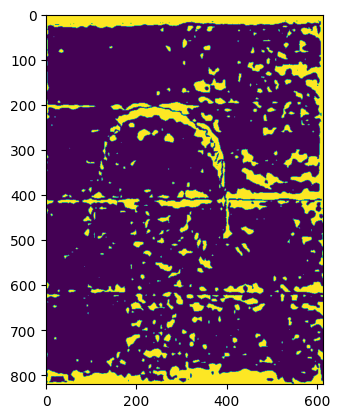

In [79]:
import matplotlib.pyplot as plt
plt.imshow(mask)

In [82]:
fwd_flow.size(), image_1.size()

(torch.Size([1, 2, 820, 615]), torch.Size([1, 3, 832, 624]))

In [95]:
image_1 = cv2.imread("myimage001.jpg")
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)

image_1 = torch.from_numpy(image_1).permute(2, 0, 1)[None].float().to(device)
image_1.shape

torch.Size([1, 3, 820, 615])

In [96]:
b, c, h, w = image_1.size()
#creating a grid
y, x = torch.meshgrid(torch.arange(h), torch.arange(w)) # [H, W]
wrapped_grid_using_fwd = torch.stack([x, y], dim=0)[None].float().to(device) + fwd_flow # [2, H, W]
b, _, h, w = wrapped_grid_using_fwd.shape

normalized_wrapped_x_grid_fwd = 2 * wrapped_grid_using_fwd[:, 0] / (w - 1) - 1
normalized_wrapped_y_grid_fwd = 2 * wrapped_grid_using_fwd[:, 1] / (h - 1) - 1

# we do this to make sampling operation function work
normalized_wrapped_grid_fwd = torch.stack([normalized_wrapped_x_grid_fwd, normalized_wrapped_y_grid_fwd], dim=-1) # [B, H, W, 2]

wrapped_image_1_with_fwd = F.grid_sample(image_1, normalized_wrapped_grid_fwd, mode="bilinear", padding_mode="zeros", align_corners=True)



In [97]:
image = wrapped_image_1_with_fwd[0].permute(1,2,0).cpu().numpy() * (1 - mask).astype('uint8')

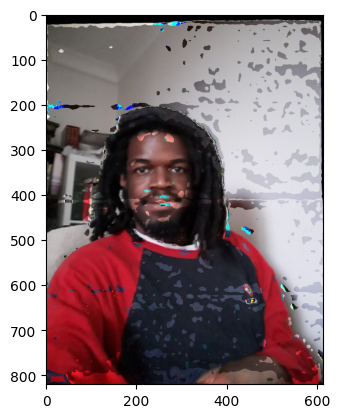

In [98]:
plt.imshow(image.astype('uint8'))

In [99]:
image = wrapped_image_1_with_fwd[0].permute(1,2,0).cpu().numpy() * (1 - (mask/255)).astype('uint8')

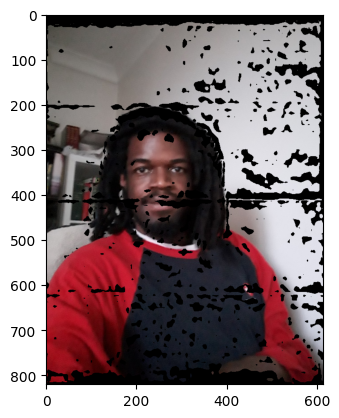

In [100]:
plt.imshow(image.astype('uint8'))